In [5]:
import numpy as np
#np.random.seed(42)

import matplotlib.pyplot as plt
%matplotlib inline

# Form Factor of a Sphere (i, ii)

In [6]:
def ptDistance(x1, x2, y1, y2, z1, z2):
        return np.sqrt(np.square(x1 - x2) + np.square(y1 - y2) + np.square(z1 - z2))

#rejection method
def genSphereFromRejection(radius, N):
    #dont get all N in sphere when sampling from cube, so multiply by 2 for crude estimate
    x = np.random.uniform(-1, 1, N) 
    y = np.random.uniform(-1, 1, N) 
    z = np.random.uniform(-1, 1, N) 
    def rejectionCriteria(x, y, z, radius):
        return np.square(x) + np.square(y) + np.square(z) <= np.square(radius)
    cond = rejectionCriteria(x, y, z, radius) #mask
    reject, = np.where(~cond) #rejection layer
    #loop to reach N total values that satisfy criteria
    while reject.size > 0:
        fillX, fillY, fillZ = np.random.uniform(-1, 1, reject.size), np.random.uniform(-1, 1, reject.size), np.random.uniform(-1, 1, reject.size)
        cond = rejectionCriteria(fillX, fillY, fillZ, radius)
        x[reject[cond]], y[reject[cond]], z[reject[cond]] = fillX[cond], fillY[cond], fillZ[cond]
        reject = reject[~cond]
    return x, y, z

#CDF ~ (r/R)^3 from infinitesimal surface area dA = r^2sinφdrdφdθ
#inspiration from http://6degreesoffreedom.co/circle-random-sampling/ 
#and http://extremelearning.com.au/how-to-generate-uniformly-random-points-on-n-spheres-and-n-balls/
def genSphereFromCDF(radius, N):
    #N uniform random numbers
    u = np.random.uniform(0, 1, N)
    #take N random cos(theta) values
    costheta = np.random.uniform(-1, 1, N)
    phi = np.random.uniform(0, 2*np.pi, N)
    
    theta = np.arccos(costheta)
    r = radius * np.cbrt(u)
    
    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)
    
    return x, y, z
    

def estimateSphereFormFactor(q, radius, N):
    x, y, z = genSphereFromRejection(radius, N)
    #x, y, z = genSphereFromCDF(radius, N)
    Pq = 0.0
    for i in np.arange(N-1):
        for j in np.arange(i+1, N):
            Pq += (np.sin(q * ptDistance(x[i], x[j], y[i], y[j], z[i], z[j]))) / (q * ptDistance(x[i], x[j], y[i], y[j], z[i], z[j]))
    return (2 / (N*(N - 1))) * Pq

def exactSphereFormFactor(q, R):
    return ((3 / ((q * R) **3)) * (np.sin(q * R) - (q * R) * np.cos(q * R))) ** 2

Error ~= 0.0004310496520914431


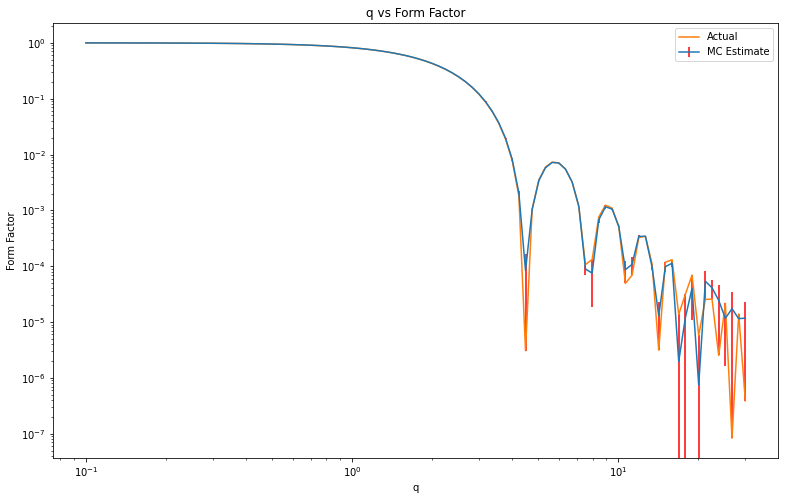

In [7]:
#geomspace takes endpoints and logarithmically equispaces all pts between
q = np.geomspace(0.1, 30, num=100)
P_est = np.empty((10, 100))

#run 10 MC simulations
for i in range(10):
    P_est[i, :] = estimateSphereFormFactor(q, 1, 1000)

#get an average value from MC iterations and take absolute value since Form Factor cannot be negative
P_avg = np.abs(np.average(P_est, axis = 0))
P_act = exactSphereFormFactor(q, 1.0) #exact value from given equation
P_err = np.abs(P_act - P_avg)
print("Error ~=", np.std(P_err))

#plot estimate vs actual
fig, ax = plt.subplots(figsize=(13,8))
ax.set_xscale("log")
ax.set_yscale("log")

ax.errorbar(q, P_avg, yerr = P_err, ecolor = 'r', label = 'MC Estimate')
ax.plot(q, P_act, label = 'Actual')
ax.set_xlabel("q")
ax.set_ylabel("Form Factor")
ax.set_title("q vs Form Factor")
ax.legend()
plt.show()

# Form Factor of a Hemi-sphere (iii)

In [17]:
#rejection method
def genHemisphereFromRejection(radius, N):
    #sample half a unit cube to simulate a hemisphere
    x = np.random.uniform(-1, 1, N) 
    y = np.random.uniform(-1, 1, N) 
    z = np.random.uniform(0, 1, N) 
    def rejectionCriteria(x, y, z, radius):
        return np.square(x) + np.square(y) + np.square(z) <= np.square(radius)
    cond = rejectionCriteria(x, y, z, radius) #mask
    reject, = np.where(~cond) #rejection layer
    #loop to reach N total values that satisfy criteria
    while reject.size > 0:
        fillX, fillY, fillZ = np.random.uniform(-1, 1, reject.size), np.random.uniform(-1, 1, reject.size), np.random.uniform(-1, 1, reject.size)
        cond = rejectionCriteria(fillX, fillY, fillZ, radius)
        x[reject[cond]], y[reject[cond]], z[reject[cond]] = fillX[cond], fillY[cond], fillZ[cond]
        reject = reject[~cond]
    return x, y, z

def genHemisphereFromCDF(radius, N):
    #N uniform random numbers
    u = np.random.uniform(0, 1, N)
    #take N random cos(theta) values for half circle
    costheta = np.random.uniform(-1, 1, N)
    phi = np.random.uniform(np.pi, 2*np.pi, N)
    
    theta = np.arccos(costheta)
    r = radius * np.cbrt(u)
    
    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)
    
    return x, y, z

def estimateHemisphereFormFactor(q, radius, N):
    x, y, z = genHemisphereFromRejection(radius, N)
    #x, y, z = genHemisphereFromCDF(radius, N)
    Pq = 0.0
    for i in np.arange(N-1):
        for j in np.arange(i+1, N):
            Pq += (np.sin(q * ptDistance(x[i], x[j], y[i], y[j], z[i], z[j]))) / (q * ptDistance(x[i], x[j], y[i], y[j], z[i], z[j]))
    return (2 / (N*(N - 1))) * Pq

Estimated Error (stdev):  0.43797708268342234


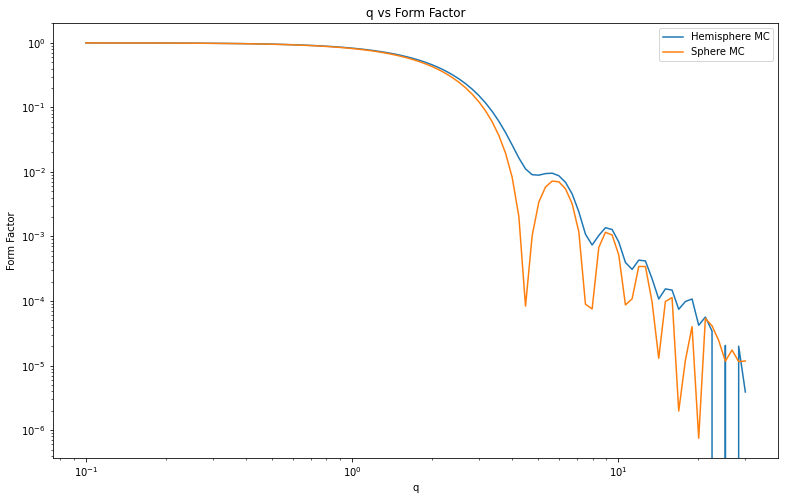

In [18]:
hemiP_est = np.empty((10, 100))

#run 10 MC simulations
for i in range(10):
    hemiP_est[i, :] = estimateHemisphereFormFactor(q, 1, 1000)

#get an average value from MC iterations
hemiP_avg = np.average(hemiP_est, axis = 0)
hemiP_err = np.std(hemiP_avg)
print('Estimated Error (stdev): ', hemiP_err)

#plot hemisphere vs sphere
plt.figure(figsize=(13, 8))
plt.loglog(q, hemiP_avg, label = 'Hemisphere MC')
plt.loglog(q, P_avg, label = 'Sphere MC')
plt.xlabel("q")
plt.ylabel("Form Factor")
plt.title("q vs Form Factor")
plt.legend()
plt.show()

# MC Discussion (iv)

Using MC integration to evaluate the Debye formula comes with several advantages and disadvantages. To begin with the main advantage, MC integration allows us to more easily approximate the complicated integral associated with the Debye formula instead of calculating it directly. Although this is still an estimate, we can see from the first plot that it almost identically matches for low *q*. A disadvantage of using the MC integration technique is that it becomes computationally expensive for higher MC samples at each *q*, leading to very slow computation times.